# Final Project: Advanced Programming DATA 602

Andrew Bowen    
CUNY School of Professional Studies    
DATA602: Advanced Programming Techniques    

# Abstract
This project presents an overview of poverty rates within different New York City municipal areas. I used data from NYC Open Data related to poverty rates within different geographic areas of the city in the year 2020. These rates were defined over the NYC Public Use Microdata Areas (PUMAs). These are geographic areas used for statistical analysis of the city. I create spatial visualizations of poverty rates across the city. In addition, I use data published by the NYPD on NYC Open Data containing arrest records for crimes within 2020. These datasets are later combined to test whether arrest counts and poverty rates are correlated. In addition, I run a one-way ANOVA test between boroughs to see if there is a statistically significant difference in poverty rates between New York City boroughs.

## Introduction
The long-term trend of [declining poverty rates in the United States has reversed in the past few years](https://www.census.gov/newsroom/stories/poverty-awareness-month.html) is well-documented. However, within New York City, poverty rates are [above the national average](https://www.osc.state.ny.us/reports/new-yorkers-need-look-poverty-trends-new-york-state-last-decade#:~:text=In%202021%2C%20the%20most%20recent,in%20the%20State%27s%20largest%20cities.), with rates even higher for certain demographic groups. In this project I investigate the geographic distribution of poverty rates in New York City, as well as differences between poverty rates of different demographic groups in New York. In addition, I look at other social factors that could be related to poverty rates. It should be noted that causal relationships **should not necessarily** be inferred from the data presented. The root causes of poverty within a city (lack of education, crime, access to housing, etc.) are difficult to enumerate, and even more difficult to prove causailty from.

## Data Sources

I found open-source datasets included on [NYCOpen Data](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi3uZnsrJr-AhVrkIkEHToLAkwQFnoECAYQAQ&url=https%3A%2F%2Fopendata.cityofnewyork.us%2F&usg=AOvVaw3hMgMsrOdIKW8WMDwBACaY). I chose this dataset showing the [financial health of different NYC neighborhoods](https://data.cityofnewyork.us/Business/Neighborhood-Financial-Health-Digital-Mapping-and-/r3dx-pew9) for 2020. This dataset includes the median salary, as well as other demographic indicators. This dataset is based off of [NYC's Neighborhood Financial Health mapping tool](https://www.nyc.gov/assets/dca/NFHI/NFHI/Index.html). I uploaded the CSV of this dataset to my [GitHub](https://raw.githubusercontent.com/andrewbowen19/advancedProgrammingData602/main/data/nyc-poverty-puma.csv) for the ability for others to reproduce. 


- [Financial Health by NYC Neighborhood](https://data.cityofnewyork.us/Business/Neighborhood-Financial-Health-Digital-Mapping-and-/r3dx-pew9) 💰
- [NYC PUMA Boundaries](https://data.cityofnewyork.us/Housing-Development/2010-Public-Use-Microdata-Areas-PUMAs-/cwiz-gcty) 🗺️

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from shapely.geometry import Point

from scipy.stats.stats import pearsonr, f_oneway

/var/folders/60/nwdftyjj6cg3ysz_pf9stwtc0000gn/T/ipykernel_44269/1866838936.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, f_oneway
/var/folders/60/nwdftyjj6cg3ysz_pf9stwtc0000gn/T/ipykernel_44269/1866838936.py:8: DeprecationWarning: Please use `f_oneway` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, f_oneway


In [223]:
# Reading in file from github
file_path = "https://raw.githubusercontent.com/andrewbowen19/advancedProgrammingData602/main/data/nyc-poverty-puma.csv"

df = pd.read_csv(file_path)

df.head()

,Year Published,PUMA,Borough,Neighborhoods,CD,Join,NYC_Poverty_Rate,Median_Income,Perc_White,Perc_Black,...,Ind6Rank,Ind6Definition,Ind7,Ind7Outcome,Ind7Rank,Ind7Definition,Ind8,Ind8Outcome,Ind8Rank,Ind8Definition
0,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,32.0,Percentage of jobs in small businesses (less t...,Participatory Budgeting,0.071777,26.0,Percentage of eligible residents casting a vot...,NaN,NaN,NaN,NaN
1,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,38.0,Percentage of bank & credit union branches off...,Mobile Banking Utilization,0.205800,23.0,Estimated percentage of residents that used mo...,NaN,NaN,NaN,NaN
2,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,27.0,Number of pre-foreclosure notices issued per 1...,Financial Counseling,0.000000,40.0,Full-Time Equivalent Financial Counselors per ...,NaN,NaN,NaN,NaN
3,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,41.0,Average (mean) travel time to work in minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,28.0,Percentage of people eligible for SNAP receivi...,Tax Credit Utilization,0.966000,9.0,Percentage of eligible Tax Units claiming EITC,Adults With High School Diploma,0.845032,21.0,Percentage of adults with a high school degree...


## Data Cleaning
We'll need to perform some cleaning steps on our data

- Convert columns to `snake_case`
- Handle missing values in numeric columns
- Join our income data to our NYC 

In [224]:
# convert dataframe columns to snake_case
new_cols = [c.replace(" ", "_").lower() for c in df.columns]
df.columns = new_cols

# clean some edge case columns
renamed_cols = {"yearpublished": "year_published"}
df = df.rename(columns=renamed_cols)

df.head()

,year_published,puma,borough,neighborhoods,cd,join,nyc_poverty_rate,median_income,perc_white,perc_black,...,ind6rank,ind6definition,ind7,ind7outcome,ind7rank,ind7definition,ind8,ind8outcome,ind8rank,ind8definition
0,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,32.0,Percentage of jobs in small businesses (less t...,Participatory Budgeting,0.071777,26.0,Percentage of eligible residents casting a vot...,NaN,NaN,NaN,NaN
1,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,38.0,Percentage of bank & credit union branches off...,Mobile Banking Utilization,0.205800,23.0,Estimated percentage of residents that used mo...,NaN,NaN,NaN,NaN
2,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,27.0,Number of pre-foreclosure notices issued per 1...,Financial Counseling,0.000000,40.0,Full-Time Equivalent Financial Counselors per ...,NaN,NaN,NaN,NaN
3,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,41.0,Average (mean) travel time to work in minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,3701,Bronx,"Riverdale, Fieldston & Kingsbridge",BX Community District 8,3701,0.152,30437,0.324,0.124,...,28.0,Percentage of people eligible for SNAP receivi...,Tax Credit Utilization,0.966000,9.0,Percentage of eligible Tax Units claiming EITC,Adults With High School Diploma,0.845032,21.0,Percentage of adults with a high school degree...


In [225]:
# Getting NYC shapefile to overlay plot
nyc = geopandas.read_file("puma_nyc_boundaries.zip")
nyc.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911..."
1,3702,1.889936e+08,106167.615361,"POLYGON ((-73.79323 40.88282, -73.79417 40.882..."
2,3703,2.676248e+08,304580.313345,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062145e+08,47984.759911,"POLYGON ((-73.82834 40.86089, -73.82843 40.860..."
4,3705,1.224877e+08,68720.860104,"POLYGON ((-73.87056 40.87151, -73.87054 40.869..."


Now we'll join our income data (`df`) to our `nyc` geopandas dataframe.

Text(0.5, 1.0, 'NYC Median Income by Municipal Area')

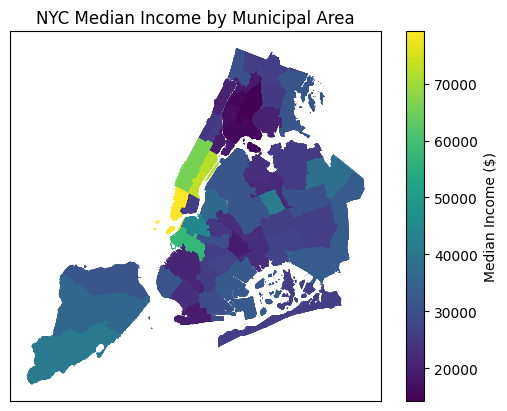

In [226]:
# Joining dtaa on puma key
nyc['puma'] = nyc.puma.astype(int)
nyc = pd.merge(nyc, df[['puma',
                        'median_income',
                        'perc_white', 
                        'perc_black',
                        'perc_hispanic',
                        'perc_asian',
                        'perc_other',
                        'nyc_poverty_rate']], on='puma', how='left')

# Plotting median income by PUMA choropleth
f, ax = plt.subplots()
nyc.plot(column='median_income', ax=ax, legend=True,
                legend_kwds={'label': "Median Income ($)",
                             'orientation': "vertical"})

# Removing lat & long for cleaner plot
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title("NYC Median Income by Municipal Area")

We could also plot the poverty rate (`nyc_poverty_rate`) column present in our data by NYC neighborhood

Text(0.5, 1.0, 'NYC Poverty Rate by Municipal Area')

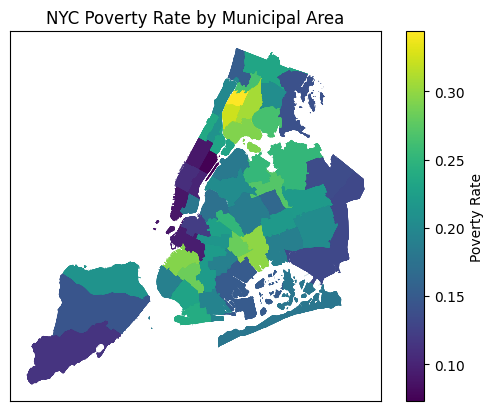

In [227]:
# Plotting poverty rate by 
f, ax = plt.subplots()
nyc.plot(column='nyc_poverty_rate', ax=ax, legend=True,
                legend_kwds={'label': "Poverty Rate",
                             'orientation': "vertical"})

# Cleaning up graph ticks and labels
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title("NYC Poverty Rate by Municipal Area")

It's not surprising that median income and poverty rate within a municipal area are inversely related. One other interesting set of variables in our dataset are the demographic breakdowns of different NYC municipal areas. For instance, the percentages of different racial groups (e.g., `perc_white`, `perc_black`, etc) are also included in our dataset. We can create a panel plot, showing the median income & poverty level of different municipal areas, as a function of their demographic breakdown (on the x-axis)

Axes(0.125,0.53;0.133621x0.35)
Axes(0.285345,0.53;0.133621x0.35)
Axes(0.44569,0.53;0.133621x0.35)
Axes(0.606034,0.53;0.133621x0.35)
Axes(0.766379,0.53;0.133621x0.35)


Text(0, 0.5, 'Poverty Rate by Municipal Area')

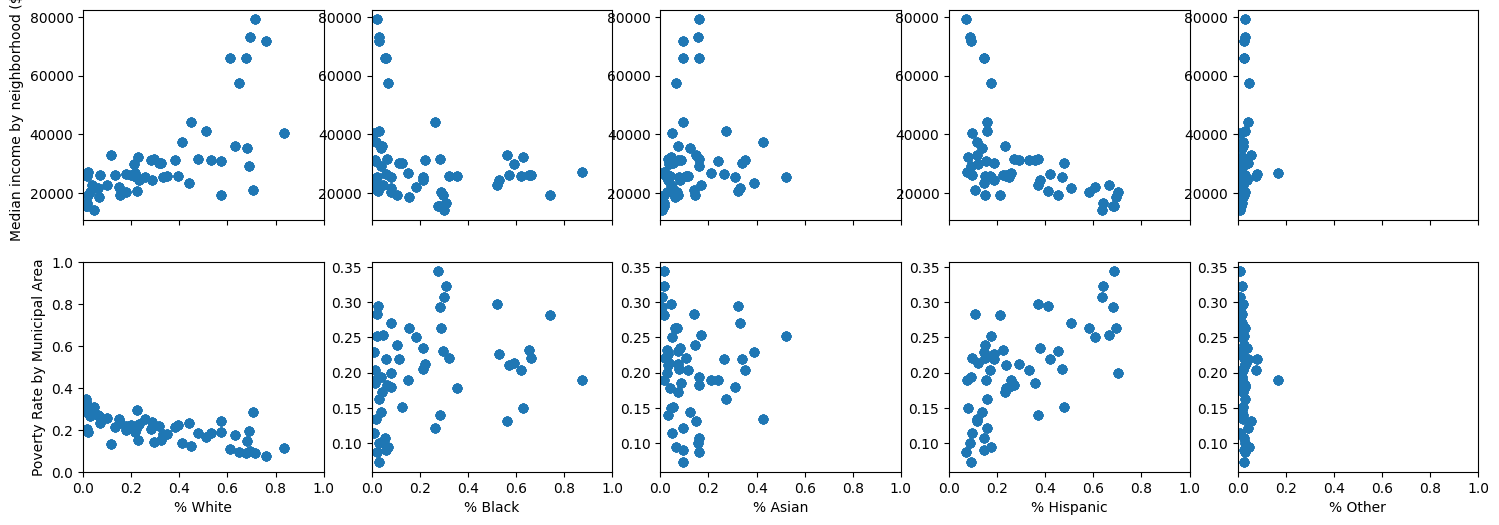

In [228]:
# Iterating over demographic groupings by ethinicity and plotting
ethnicities = ["white", "black", "asian", "hispanic", "other"]
f, axes = plt.subplots(2, 5, figsize=(18, 6), sharex=True, squeeze=True)


for i, e in enumerate(zip(axes[0], ethnicities)):
    
    
    axis = e[0]
    print(axis)
    ethnicity_label = f"perc_{e[1]}"
    graph_x_label = f"% {e[1].title()}"

    # Plot median income vs percentage of population
    axis.scatter(df[ethnicity_label], df.median_income)
    axis.set_xlim(0, 1)

    # Plot poverty rates on bottom row of panel
    bottom_axis = axes[1][i]
    bottom_axis.scatter(df[ethnicity_label], df.nyc_poverty_rate)
    bottom_axis.set_xlim(0, 1)
    bottom_axis.set_xlabel(graph_x_label)

# Set y axis labels
axes[0][0].set_ylabel("Median income by neighborhood ($)")
axes[1][0].set_ylim(0, 1)
axes[1][0].set_ylabel("Poverty Rate by Municipal Area")


### Borough-level aggregation
Aggregating our dataset to a borough level is of interest as well.

In [229]:
# We can do this aggregation easily by the pandas groupby funciton
df.groupby('borough')[['median_income', 'nyc_poverty_rate']].mean(["median_income", "nyc_poverty_rate"])

,median_income,nyc_poverty_rate
borough,,
Bronx,21453.900000,0.252500
Brooklyn,28471.444444,0.215167
Manhattan,47216.400000,0.151500
Queens,29391.571429,0.199357
Staten Island,35799.000000,0.156667


### Crime data
There is crime & arrest data available for [NYC in this open dataset](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u/explore/query/SELECT%0A%20%20%60arrest_key%60%2C%0A%20%20%60arrest_date%60%2C%0A%20%20%60pd_cd%60%2C%0A%20%20%60pd_desc%60%2C%0A%20%20%60ky_cd%60%2C%0A%20%20%60ofns_desc%60%2C%0A%20%20%60law_code%60%2C%0A%20%20%60law_cat_cd%60%2C%0A%20%20%60arrest_boro%60%2C%0A%20%20%60arrest_precinct%60%2C%0A%20%20%60jurisdiction_code%60%2C%0A%20%20%60age_group%60%2C%0A%20%20%60perp_sex%60%2C%0A%20%20%60perp_race%60%2C%0A%20%20%60x_coord_cd%60%2C%0A%20%20%60y_coord_cd%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20%60lon_lat%60%2C%0A%20%20%60%3A%40computed_region_efsh_h5xi%60%2C%0A%20%20%60%3A%40computed_region_f5dn_yrer%60%2C%0A%20%20%60%3A%40computed_region_yeji_bk3q%60%2C%0A%20%20%60%3A%40computed_region_92fq_4b7q%60%2C%0A%20%20%60%3A%40computed_region_sbqj_enih%60%0AWHERE%0A%20%20%60arrest_date%60%0A%20%20%20%20BETWEEN%20%222020-01-01T14%3A00%3A48%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222021-01-01T14%3A00%3A48%22%20%3A%3A%20floating_timestamp/page/filter). I filtered the data linked to just the year of 2020, as that's the timespan of our poverty data set. I then exported the data in CSV format and posted it to [my GitHub here](https://github.com/andrewbowen19/advancedProgrammingData602/blob/main/data/NYPD_Arrests_Data__Historic_.csv) (I do not claim ownership of this data, this is for educational purposes.) We can join this into our existing dataset to analyze the effect of crime on a region as it relates to poverty rates.

In [230]:
# Reading in our crime dataset
crime_url = "https://raw.githubusercontent.com/andrewbowen19/advancedProgrammingData602/main/data/NYPD_Arrests_Data__Historic_.csv"
crimes = pd.read_csv(crime_url)
crimes.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,206907372,01/02/2020,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Q,112,...,1025420,202485,40.722364,-73.851474,POINT (-73.85147389399998 40.72236368700005),14786.0,40.0,3.0,28.0,70.0
1,206905372,01/02/2020,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,K,88,...,990584,193614,40.698108,-73.977159,POINT (-73.97715882199996 40.69810842400005),17212.0,68.0,2.0,38.0,55.0
2,206906721,01/02/2020,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200507,F,B,52,...,1017440,256046,40.869407,-73.879998,POINT (-73.87999831299999 40.86940749200004),11605.0,24.0,5.0,40.0,34.0
3,206900478,01/02/2020,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200504,F,Q,103,...,1037598,194471,40.700302,-73.807603,POINT (-73.80760338 40.70030215500003),24670.0,41.0,3.0,6.0,61.0
4,206906396,01/02/2020,750.0,RESISTING ARREST,359.0,OFFENSES AGAINST PUBLIC ADMINI,PL 2053000,M,B,40,...,1006075,236932,40.816981,-73.921152,POINT (-73.92115225499998 40.81698058400008),10929.0,49.0,5.0,43.0,23.0


Let's do some quick cleaning of our crime data, before integrating it with the poverty dataset

- `snake_case` columns
- Enfore correct data typing where appropriate

In [231]:
# snake case columns
cleaned_cols = [c.lower().replace(" ", "_") for c in crimes.columns]
crimes.columns = cleaned_cols

# Map
borough_mapping = {
                   "K": "Brooklyn",
                   "B": "Bronx",
                   "Q": "Queens",
                   "M": "Manhattan",
                   "S": "Staten Island"
                   }
crimes['arrest_boro'] = crimes.arrest_boro.replace(borough_mapping)

crimes['arrest_date'] = pd.to_datetime(crimes.arrest_date)
crimes.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,...,x_coord_cd,y_coord_cd,latitude,longitude,lon_lat,zip_codes,community_districts,borough_boundaries,city_council_districts,police_precincts
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,1025420,202485,40.722364,-73.851474,POINT (-73.85147389399998 40.72236368700005),14786.0,40.0,3.0,28.0,70.0
1,206905372,2020-01-02,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,Brooklyn,88,...,990584,193614,40.698108,-73.977159,POINT (-73.97715882199996 40.69810842400005),17212.0,68.0,2.0,38.0,55.0
2,206906721,2020-01-02,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200507,F,Bronx,52,...,1017440,256046,40.869407,-73.879998,POINT (-73.87999831299999 40.86940749200004),11605.0,24.0,5.0,40.0,34.0
3,206900478,2020-01-02,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200504,F,Queens,103,...,1037598,194471,40.700302,-73.807603,POINT (-73.80760338 40.70030215500003),24670.0,41.0,3.0,6.0,61.0
4,206906396,2020-01-02,750.0,RESISTING ARREST,359.0,OFFENSES AGAINST PUBLIC ADMINI,PL 2053000,M,Bronx,40,...,1006075,236932,40.816981,-73.921152,POINT (-73.92115225499998 40.81698058400008),10929.0,49.0,5.0,43.0,23.0


In [232]:
# Getting counts of crimes by borough and crime type
crimes.groupby(["arrest_boro", "ofns_desc"])[['arrest_boro', 'ofns_desc']].count()

arrest_boro  ofns_desc
arrest_boro   ofns_desc                                                   
Bronx         ADMINISTRATIVE CODE                            19         19
              AGRICULTURE & MRKTS LAW-UNCLASSIFIED            8          8
              ALCOHOLIC BEVERAGE CONTROL LAW                 92         92
              ANTICIPATORY OFFENSES                          37         37
              ARSON                                          19         19
...                                                         ...        ...
Staten Island ROBBERY                                       225        225
              SEX CRIMES                                     92         92
              THEFT-FRAUD                                    10         10
              UNAUTHORIZED USE OF A VEHICLE                  33         33
              VEHICLE AND TRAFFIC LAWS                      305        305

[265 rows x 2 columns]

We need to look up the PUMA for each row in our crime dataset, to enable choropleth plotting of crime counts. To do this, we'll need to construct a [geopandas dataframe](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) from our crime data, then determine which PUMA each crime entry occurred in (via a [spatial join](https://www.matecdev.com/posts/point-in-polygon.html#:~:text=for%20further%20analysis.-,How%20to%20check%20if%20a%20point%20is%20inside%20a%20polygon,a%20polygon%20contains%20a%20point.))

In [233]:
# Constructing a geopandas dataframe from our crime datae=
crimes = geopandas.GeoDataFrame(crimes, geometry=geopandas.points_from_xy(crimes.longitude, crimes.latitude),crs="EPSG:2263")

crimes.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,...,y_coord_cd,latitude,longitude,lon_lat,zip_codes,community_districts,borough_boundaries,city_council_districts,police_precincts,geometry
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,202485,40.722364,-73.851474,POINT (-73.85147389399998 40.72236368700005),14786.0,40.0,3.0,28.0,70.0,POINT (-73.851 40.722)
1,206905372,2020-01-02,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,Brooklyn,88,...,193614,40.698108,-73.977159,POINT (-73.97715882199996 40.69810842400005),17212.0,68.0,2.0,38.0,55.0,POINT (-73.977 40.698)
2,206906721,2020-01-02,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200507,F,Bronx,52,...,256046,40.869407,-73.879998,POINT (-73.87999831299999 40.86940749200004),11605.0,24.0,5.0,40.0,34.0,POINT (-73.880 40.869)
3,206900478,2020-01-02,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200504,F,Queens,103,...,194471,40.700302,-73.807603,POINT (-73.80760338 40.70030215500003),24670.0,41.0,3.0,6.0,61.0,POINT (-73.808 40.700)
4,206906396,2020-01-02,750.0,RESISTING ARREST,359.0,OFFENSES AGAINST PUBLIC ADMINI,PL 2053000,M,Bronx,40,...,236932,40.816981,-73.921152,POINT (-73.92115225499998 40.81698058400008),10929.0,49.0,5.0,43.0,23.0,POINT (-73.921 40.817)


In [234]:
# Looking up the municipal area where each crime entry occurred
crimes = geopandas.tools.sjoin(crimes, nyc, how='left', predicate="within")
crimes.head()

/var/folders/60/nwdftyjj6cg3ysz_pf9stwtc0000gn/T/ipykernel_44269/4105489079.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2263
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  crimes = geopandas.tools.sjoin(crimes, nyc, how='left', predicate="within")


,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,...,puma,shape_area,shape_leng,median_income,perc_white,perc_black,perc_hispanic,perc_asian,perc_other,nyc_poverty_rate
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,4108.0,7.776516e+07,37999.649684,41029.0,0.512,0.029,0.157,0.272,0.031,0.163
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,4108.0,7.776516e+07,37999.649684,41029.0,0.512,0.029,0.157,0.272,0.031,0.163
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,4108.0,7.776516e+07,37999.649684,41029.0,0.512,0.029,0.157,0.272,0.031,0.163
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,4108.0,7.776516e+07,37999.649684,41029.0,0.512,0.029,0.157,0.272,0.031,0.163
0,206907372,2020-01-02,153.0,RAPE 3,104.0,RAPE,PL 1302501,F,Queens,112,...,4108.0,7.776516e+07,37999.649684,41029.0,0.512,0.029,0.157,0.272,0.031,0.163


In [235]:
# Aggregating our crime data on the PUMA level -- interested in counts primarily
crimes_agg = pd.DataFrame(crimes.groupby(["puma",
                            "arrest_boro"])[['puma']].count()
)

# TODO: drop index for join later
crimes_agg['arrest_boro'] = crimes_agg.index.get_level_values(1)
crimes_agg['count_crimes'] = crimes_agg.puma
crimes_agg.index = crimes_agg.index.droplevel(1)
crimes_agg.head()

,puma,arrest_boro,count_crimes
puma,,,
3701.0,8701,Bronx,8701
3702.0,21784,Bronx,21784
3703.0,8897,Bronx,8897
3704.0,12390,Bronx,12390
3705.0,35056,Bronx,35056


In [236]:
# Join to nyc data for chrime counts by PUMA choropleth
nyc = nyc.join(crimes_agg,
               on='puma',
               how='left',
               rsuffix="_c")
nyc.head()

,puma,shape_area,shape_leng,geometry,median_income,perc_white,perc_black,perc_hispanic,perc_asian,perc_other,nyc_poverty_rate,puma_c,arrest_boro,count_crimes
0,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911...",30437,0.324,0.124,0.477,0.052,0.023,0.152,8701,Bronx,8701
1,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911...",30437,0.324,0.124,0.477,0.052,0.023,0.152,8701,Bronx,8701
2,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911...",30437,0.324,0.124,0.477,0.052,0.023,0.152,8701,Bronx,8701
3,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911...",30437,0.324,0.124,0.477,0.052,0.023,0.152,8701,Bronx,8701
4,3701,9.792852e+07,53227.112713,"POLYGON ((-73.89663 40.91142, -73.89663 40.911...",30437,0.324,0.124,0.477,0.052,0.023,0.152,8701,Bronx,8701


Text(0.5, 1.0, 'NYC Arrests by Municipal Area')

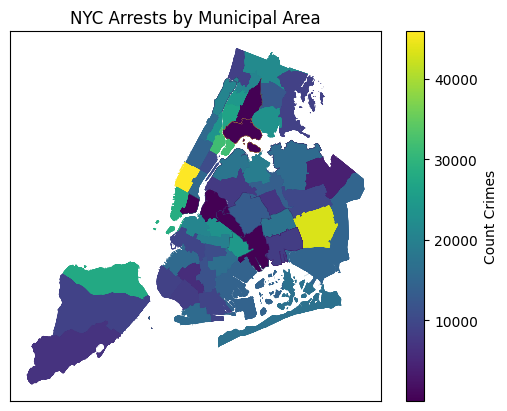

In [237]:
# Plotting raw crime counts by PUMA
f, ax = plt.subplots()
nyc.plot(column='count_crimes', ax=ax, legend=True,
                legend_kwds={'label': "Count Crimes",
                             'orientation': "vertical"})

# Cleaning up graph ticks and labels
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title("NYC Arrests by Municipal Area")

<Axes: xlabel='count_crimes', ylabel='nyc_poverty_rate'>

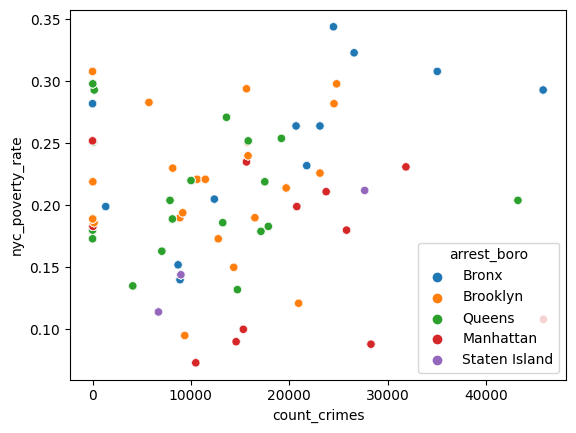

In [238]:
# Scatter plot of poverty rates and crime counts by PUMA using seaborn
nyc_data = pd.DataFrame(nyc)
sns.scatterplot(data=nyc_data,
                x='count_crimes',
                y='nyc_poverty_rate',
                hue=nyc['arrest_boro'], palette='tab10')

Ideally we'd control the above data by population. An area with 100k inhabitants will most likely have more arrests & crimes than one with only 1,000 residents. Incorporating population data into our analysis could be the result of future work.

## Statistical Testing

I'd like to see if there is a correlation between the variables of crime counts and poverty rates within a given PUMA in NYC. We can use the [`pearsonr` function from `scipy` in order to see if there is a correlation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html). 

In [239]:
# Getting Pearson's correlation coefficient from our variables
corr = pearsonr(nyc.count_crimes.values, nyc.nyc_poverty_rate.values)
corr

PearsonRResult(statistic=0.08833947165941772, pvalue=0.05409947955857818)

We can also perform a one-way ANOVA test to see if the difference in poverty rates between boroughs is statistically significant. We need to show the [three conditions below are satisfied](https://www.tibco.com/reference-center/what-is-analysis-of-variance-anova#:~:text=Reference%20Center-,What%20is%20Analysis%20of%20Variance%20(ANOVA)%3F,the%20means%20of%20different%20groups.) for ANOVA:

- **Independence of Observations:** The poverty rate in one neighborhood is independent of another. 
- **Normality:** The dependent variable is normally dstributed
- **Homoscedasticity**: The variance of the different groups are roughly equal

(array([35., 21., 42., 42., 98., 91., 42., 42., 49., 14.]),
 array([0.073 , 0.1001, 0.1272, 0.1543, 0.1814, 0.2085, 0.2356, 0.2627,
        0.2898, 0.3169, 0.344 ]),
 <BarContainer object of 10 artists>)

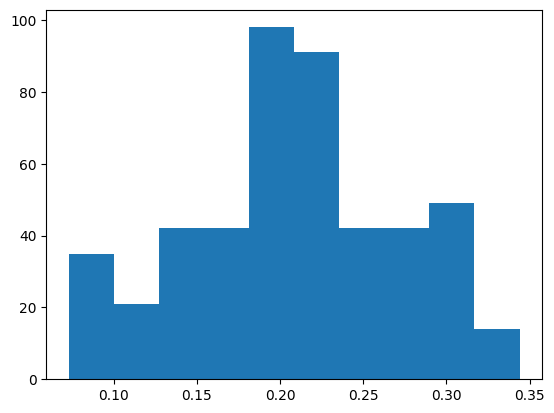

In [240]:
# Plotting poverty rates to asses normality
plt.hist(nyc_data.nyc_poverty_rate)

In [241]:
nyc_data.groupby("boro_code")['nyc_poverty_rate'].var()

KeyError: 'boro_code'

These look to be within a similar ballpark and are of the same order of magnitude. We could run more tests for statistical rigor, but should be ok to run an ANOVA for our purposes. Lastly, let's run our ANOVA test with a significance level of 0.05 on our data

In [ ]:
# Map categorical group variables (boro) to numeric
nyc_data['boro_code'] = nyc_data['arrest_boro'].replace({b: i for i, b in enumerate(nyc_data.arrest_boro.unique())})

# Run one-way ANOVA
f_oneway(nyc_data.boro_code, nyc_data.nyc_poverty_rate)

F_onewayResult(statistic=743.0481003184016, pvalue=2.4660698764850356e-121)

Our p-value being less than our significance level suggests that our results **are** statistically significant and that the New York City borough does have a relationship with the poverty rate. There are many other socioeconomic factors that can influence an area's poverty rate, so a correlated relationship (rather than a causal one) is all that can be inferred here.

## Conclusion
While the data used in this project can't prove causality, it's interesting to show (through both visualization and statistical testing) the differences between different areas of the city, and how different demographic factors can impact the poverty rate in a neighborhood/municipal area. Mitigating poverty is an area of policy that has spillover effects in a geographic ares ([study 1](https://www.tandfonline.com/doi/full/10.1080/1331677X.2023.2167730) & [study 2](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiO2ObTwOT-AhUhVTUKHUTADOUQFnoECBIQAQ&url=https%3A%2F%2Frepositorio.cepal.org%2Fbitstream%2Fhandle%2F11362%2F45410%2F1%2FRVI129_Araujo.pdf&usg=AOvVaw1YEjwWOH9S2C8ytvGK470I)). Performing a spatial analysis of poverty rates in a city/geographic area can be helpful in determining where officials should direct resources to combat poverty. 